# Assigment 2  --- Data Preprocessing & Exploration


### Ideas for discovering churn pattern 
- Duration  of Subscription
- Network size (intra-net call discounts): we can approximate this with the proportion of calls/messages that are "onnet" and "offnet" and we can also approximate the size of the overall network

- Quality of Service: maybe this is captured by consumer complaints? I am not certain whether they mean complaints from the consumer or to the consumer about not paying.


### Discriminative Variables
- has DataPlan
- Personal o Bussiness
- FIN_STATE

## Asumptions
- Churn is explanied for any reason of termination(Decision of client, Decision of the Telco)
- The test is going to be performend only on December 2013. Not taking into account external variables (MacroEconomics)
- The complaint data for one week and for two weeks seems to be faulty. When comparing the number of complaints for 1 week, 2 weeks, and 1 month, the aggregates do not muchin around 200 cases (where there are more complaints in the last two weeks than during the last month) and around 100 cases (where there are more complaints in the last week than in two weeks). Hence, we will focus on one month, three month, and six month data for the complaints. -(Seppe) could be due to difference on frequency on updating the data.  
- We need to decide on an approach for the complaints, one option is dropping the columnms with one week and two week complaints. Another one is dropping the observations where there is a problem with the aggregated numbers of complaints.

- Given that the financial state variable is almost perfectly correlated with the churn variable (excelpt for 69 observations in the whole dataset), we will exclude it initially. We would have to decide on how to input the missing values and it does not seem informative.
- We will initially drop customer life value given that it has outliers and it is not clear how it was computed
- 0 for clients that does not has data plan
- COUNT_ONNET_CALLS_1WEEK: Includes incoming and outgoing calls




In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split

In [9]:
#Dataset Loading
data = pd.read_csv('telco_train.csv', parse_dates=['START_DATE'])
original=data.copy()
print(" ** Number of Rows: "+str(data.shape[0])+" Number of Features: "+str(data.shape[1]-1))
print("\nProportion of Churn")
label_balance = data["CHURN"].value_counts()
print('Normal: {:8d} records {:8.3f} %'.format(label_balance[0], 100*label_balance[0]/data.shape[0]))
print('Churn:  {:8d} records {:8.3f} %'.format(label_balance[1], 100*label_balance[1]/data.shape[0]))

 ** Number of Rows: 5000 Number of Features: 37

Proportion of Churn
Normal:     3554 records   71.080 %
Churn:      1446 records   28.920 %


# 1. Initial Data Exploration
In this part we examine the structure of the data, potential missing values, the features distribution and their relationships with the label value.

### Data structure
First we gather information about the data structure, format and basic statistics.

In [6]:
data.head(5).transpose()

,0,1,2,3,4
ID,11452,16546,15607,13621,11710
CHURN,0,0,0,0,0
START_DATE,2011-02-21 00:00:00,2013-07-20 00:00:00,2013-04-29 00:00:00,2012-08-23 00:00:00,2011-06-20 00:00:00
PREPAID,0,0,0,1,0
FIN_STATE,NaN,NaN,NaN,NaN,NaN
COUNT_PAYMENT_DELAYS_CURRENT,0,0,0,0,0
COUNT_PAYMENT_DELAYS_1YEAR,4,0,2,4,3
DAYS_PAYMENT_DELAYS_CURRENT,0,0,0,0,0
DAYS_PAYMENT_DELAYS_1YEAR,8,0,47,51,11
COMPLAINT_1WEEK,0,0,0,0,0


In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,1.352571e+04,2.022044e+03,10002.00,1.179875e+04,1.352950e+04,1.526925e+04,1.703300e+04
CHURN,5000.0,2.892000e-01,4.534363e-01,0.00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
PREPAID,5000.0,2.322000e-01,4.222781e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
FIN_STATE,1377.0,4.357298e-02,2.042172e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
COUNT_PAYMENT_DELAYS_CURRENT,5000.0,1.154000e-01,4.776280e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
COUNT_PAYMENT_DELAYS_1YEAR,5000.0,2.529000e+00,2.719676e+00,0.00,1.000000e+00,2.000000e+00,4.000000e+00,1.800000e+01
DAYS_PAYMENT_DELAYS_CURRENT,5000.0,-5.229800e+00,2.722839e+01,-340.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
DAYS_PAYMENT_DELAYS_1YEAR,5000.0,3.759440e+01,1.026954e+02,0.00,1.000000e+00,9.000000e+00,2.900000e+01,1.653000e+03
COMPLAINT_1WEEK,5000.0,1.424000e-01,5.583768e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00
COMPLAINT_2WEEKS,5000.0,6.420000e-02,3.667496e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 38 columns):
ID                                 5000 non-null int64
CHURN                              5000 non-null int64
START_DATE                         5000 non-null datetime64[ns]
PREPAID                            5000 non-null int64
FIN_STATE                          1377 non-null float64
COUNT_PAYMENT_DELAYS_CURRENT       5000 non-null int64
COUNT_PAYMENT_DELAYS_1YEAR         5000 non-null int64
DAYS_PAYMENT_DELAYS_CURRENT        5000 non-null int64
DAYS_PAYMENT_DELAYS_1YEAR          5000 non-null int64
COMPLAINT_1WEEK                    5000 non-null int64
COMPLAINT_2WEEKS                   5000 non-null int64
COMPLAINT_1MONTH                   5000 non-null int64
COMPLAINT_3MONTHS                  5000 non-null int64
COMPLAINT_6MONTHS                  5000 non-null int64
CLV                                5000 non-null float64
COUNT_OFFNET_CALLS_1WEEK           5000 non-null int64


### Missing values
Checking for missing values.

In [7]:
print("Total Missing Values: " +str(data.isnull().sum().sum()))


Total Missing Values: 7652


In [8]:
col,missing=[],[]
for c in data.columns:
    num=data[c].isnull().sum()
    if num>0:
        col.append(c)
        missing.append(num)
pd.DataFrame({'Missing':missing} , index =col) 

,Missing
FIN_STATE,3623
AVG_DATA_3MONTH,1343
COUNT_CONNECTIONS_3MONTH,1343
AVG_DATA_1MONTH,1343


### Feature distribution analysis
We display the distribution of the features in order to see whether some of them need to be transformed.

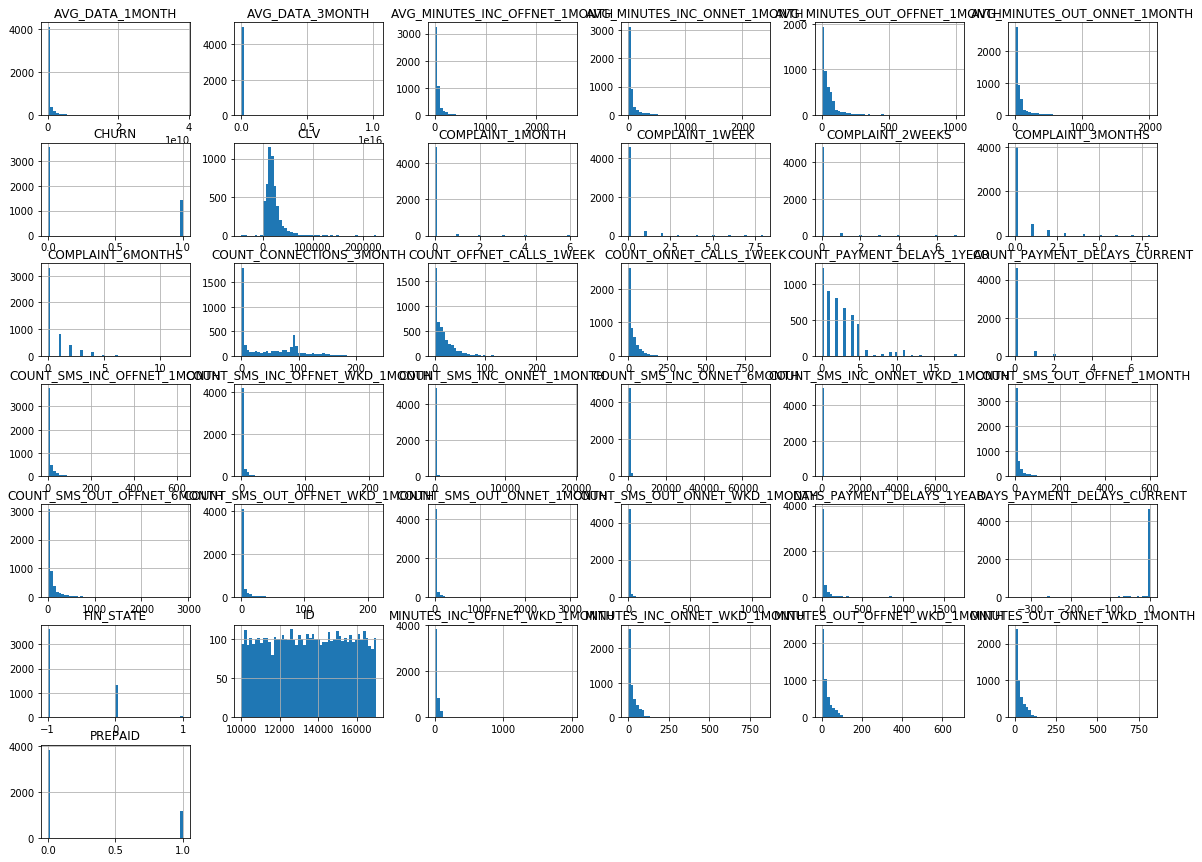

In [14]:
data.hist(bins=50,figsize=(20,15))
plt.show()

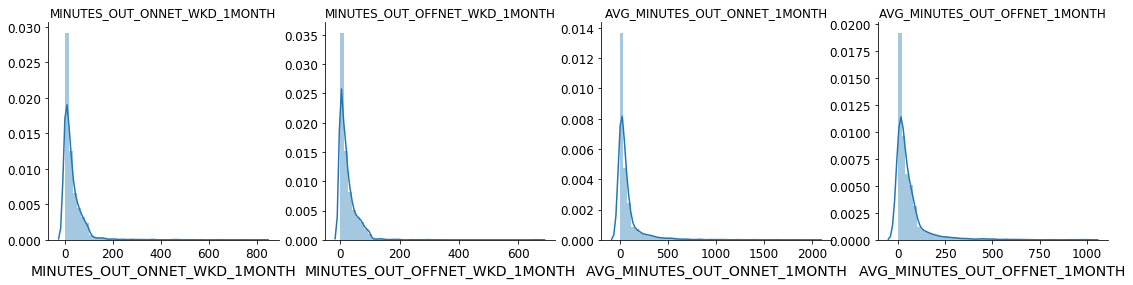

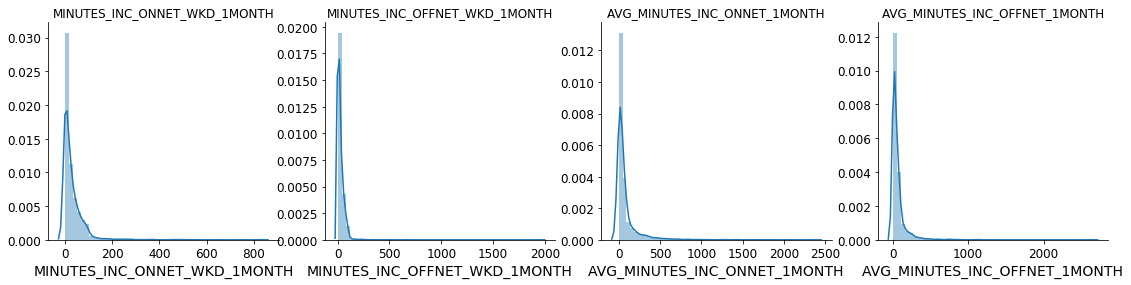

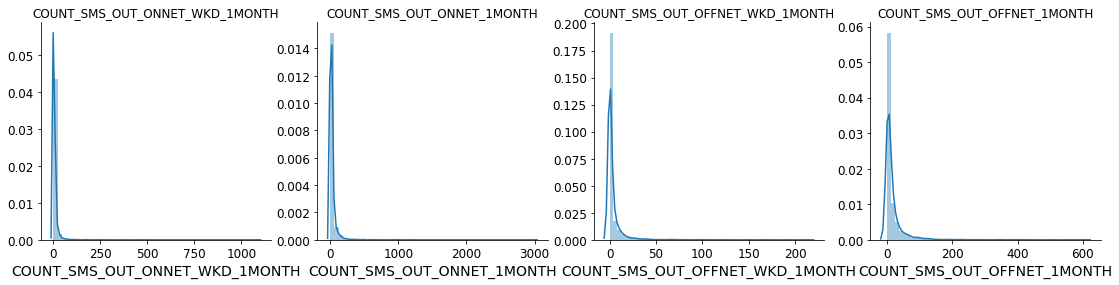

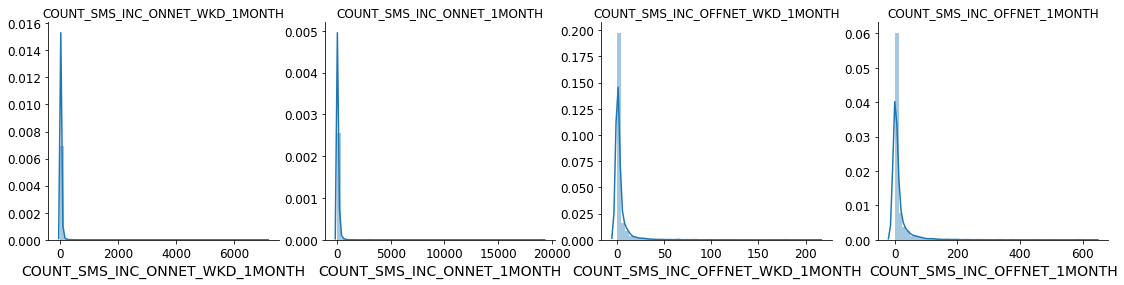

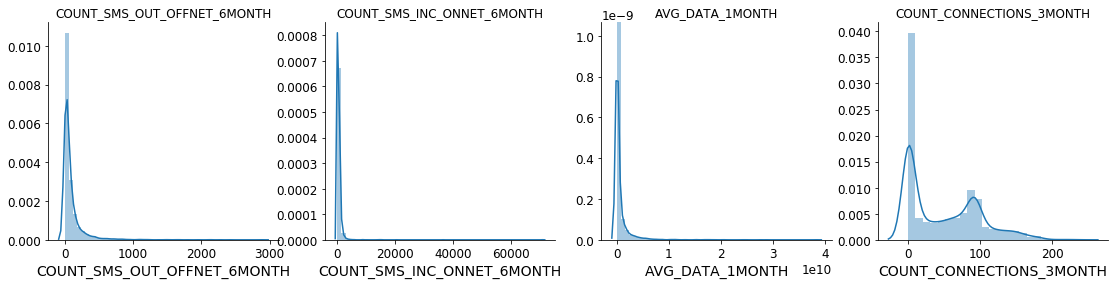

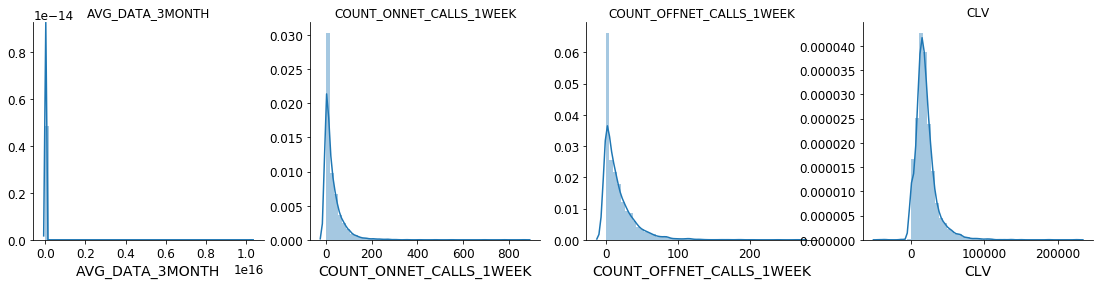

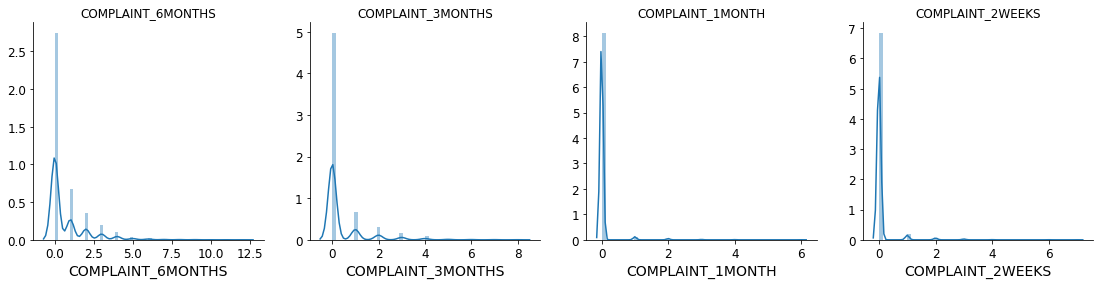

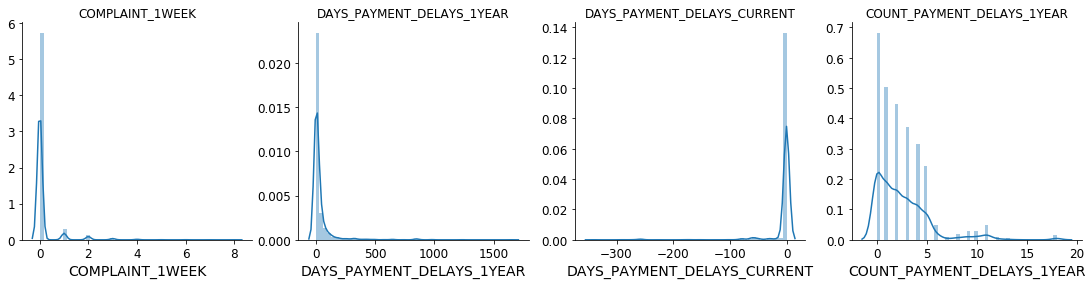

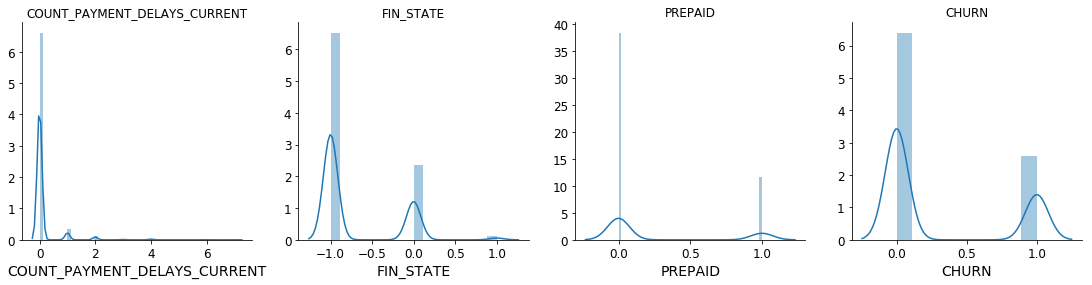

In [411]:
temp=data.drop(["START_DATE","ID"], axis=1)
rows=int(temp.shape[1]/4)
cols=4
features=list(temp.columns)
for i in range(rows):
    fig, ax5 = plt.subplots(1, cols, figsize=(19, 4))
    for j in range(cols): 
        feat=features.pop()
        #print(feat)
        sns.distplot(temp[feat], ax = ax5[j])
        ax5[j].set_title(feat)
    sns.despine()
plt.show()

### Outlier identification
We look for outliers in the dataset, using the InterQuartile Range method:

In [412]:
X = temp=data.drop(["START_DATE","ID","CHURN"], axis=1)
all_outliers = np.array([])
for feature in X.columns:
    Q1 = X[feature].quantile(.25)
    Q3 = X[feature].quantile(.75)
    IQR = float(Q3) - float(Q1)
    outliers = X[((X[feature] <= Q1 - 1.5 * IQR)
                  & (X[feature] >= Q3 + 1.5 * IQR))]
    all_outliers = np.append(all_outliers, np.array(outliers.index.values.tolist()).astype(int))
outlier_count = np.count_nonzero(np.unique(all_outliers))
print('{} outliers were identified, over {} datapoints, which represents {} %.'
      .format(outlier_count,
              X.shape[0],
              round(outlier_count/X.shape[0] * 100, 2)
             )
     )

4999 outliers were identified, over 5000 datapoints, which represents 99.98 %.


Suma: 23
Int64Index([ 102,  551,  782,  867, 1128, 1138, 1317, 2216, 2287, 2453, 2674,
            2867, 2904, 3361, 3999, 4130, 4175, 4348, 4731, 4749, 4898, 4912,
            4974],
           dtype='int64')
102     1
551     0
782     1
867     0
1128    0
1138    0
1317    0
2216    0
2287    0
2453    0
2674    0
2867    0
2904    0
3361    0
3999    1
4130    0
4175    0
4348    1
4731    1
4749    0
4898    0
4912    1
4974    1
Name: CHURN, dtype: int64


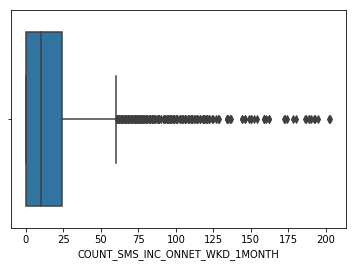

In [4]:
Q1 = data["COUNT_SMS_INC_ONNET_WKD_1MONTH"].quantile(0.25)
Q3 = data["COUNT_SMS_INC_ONNET_WKD_1MONTH"].quantile(0.75)
IQR = Q3 - Q1
#print(IQR)
mask=(data["COUNT_SMS_INC_ONNET_WKD_1MONTH"] > (Q3 + 7.5 * IQR))
print("Suma: "+str(mask.sum()))
ax = sns.boxplot(x=data["COUNT_SMS_INC_ONNET_WKD_1MONTH"][~mask])
print(data[mask].index)
print(data[mask]["CHURN"])

### Pearson Correlation Matrix
In order to analyse correlation between features, we compute a correlation matrix by the Pearson method.

In [414]:
X = temp=data.drop(["START_DATE","ID"], axis=1)
corr=X.corr(method='pearson')


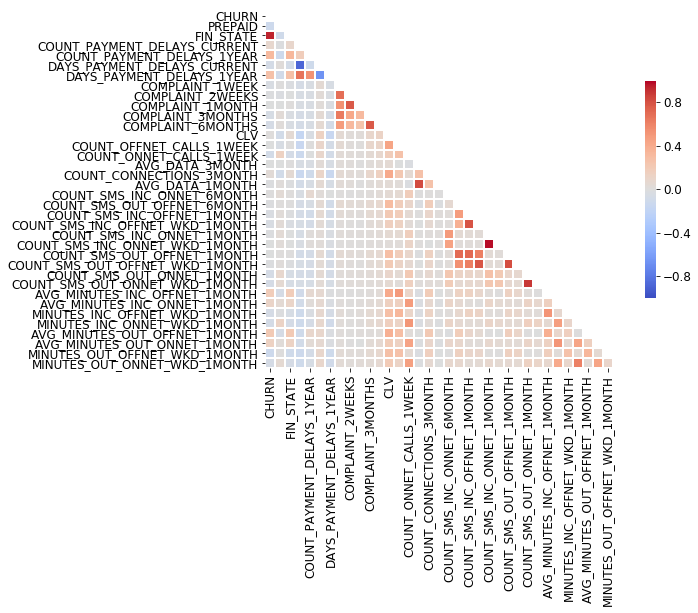

In [415]:
plt.figure(figsize=(8, 8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            yticklabels=corr.columns, 
            cmap="coolwarm", 
            #annot=True, 
            #fmt=".2f",
            mask=mask, 
            vmax=1, 
            vmin=-1,
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5})
plt.show()

In [416]:
#Plot All Features vs All Features
#plt.figure(figsize=(8, 8))
#sns.pairplot(corr, kind="reg", diag_kind="kde")
#plt.show()

### Correlation All Features vs All Features

In [417]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)    
    return au_corr[0:n]

##Usage
print("Top Absolute Correlations of features")
X = temp=data.drop(["START_DATE","ID"], axis=1)
print(get_top_abs_correlations(X, 50))


Top Absolute Correlations of features
COUNT_SMS_INC_ONNET_1MONTH       COUNT_SMS_INC_ONNET_WKD_1MONTH     0.981012
CHURN                            FIN_STATE                          0.941955
COUNT_SMS_OUT_ONNET_1MONTH       COUNT_SMS_OUT_ONNET_WKD_1MONTH     0.886078
COUNT_PAYMENT_DELAYS_CURRENT     DAYS_PAYMENT_DELAYS_CURRENT        0.878456
AVG_DATA_3MONTH                  AVG_DATA_1MONTH                    0.824631
COUNT_SMS_OUT_OFFNET_1MONTH      COUNT_SMS_OUT_OFFNET_WKD_1MONTH    0.814240
COUNT_SMS_INC_OFFNET_1MONTH      COUNT_SMS_INC_OFFNET_WKD_1MONTH    0.794831
COUNT_SMS_INC_OFFNET_WKD_1MONTH  COUNT_SMS_OUT_OFFNET_WKD_1MONTH    0.786045
COMPLAINT_3MONTHS                COMPLAINT_6MONTHS                  0.770610
COMPLAINT_2WEEKS                 COMPLAINT_1MONTH                   0.766765
COUNT_SMS_INC_OFFNET_1MONTH      COUNT_SMS_OUT_OFFNET_1MONTH        0.717318
COUNT_SMS_OUT_OFFNET_6MONTH      COUNT_SMS_OUT_OFFNET_1MONTH        0.703732
COMPLAINT_1WEEK                  COMPL

### Correlation All features vs CHURN

In [418]:
X.corr().abs().unstack().loc["CHURN"].sort_values(ascending=False)[1:] 

FIN_STATE                          0.941955
COUNT_PAYMENT_DELAYS_1YEAR         0.315989
DAYS_PAYMENT_DELAYS_1YEAR          0.267423
AVG_MINUTES_OUT_OFFNET_1MONTH      0.204979
AVG_MINUTES_INC_OFFNET_1MONTH      0.185686
AVG_MINUTES_OUT_ONNET_1MONTH       0.134657
AVG_MINUTES_INC_ONNET_1MONTH       0.113864
MINUTES_OUT_OFFNET_WKD_1MONTH      0.113006
PREPAID                            0.111345
COUNT_PAYMENT_DELAYS_CURRENT       0.081376
COUNT_ONNET_CALLS_1WEEK            0.073884
MINUTES_INC_ONNET_WKD_1MONTH       0.064792
DAYS_PAYMENT_DELAYS_CURRENT        0.063503
MINUTES_OUT_ONNET_WKD_1MONTH       0.061025
COUNT_SMS_OUT_ONNET_1MONTH         0.060771
COMPLAINT_6MONTHS                  0.060622
MINUTES_INC_OFFNET_WKD_1MONTH      0.060345
COUNT_SMS_OUT_ONNET_WKD_1MONTH     0.058564
COMPLAINT_3MONTHS                  0.049765
COUNT_CONNECTIONS_3MONTH           0.038646
COUNT_SMS_INC_OFFNET_WKD_1MONTH    0.038153
COMPLAINT_1WEEK                    0.033937
COUNT_SMS_INC_OFFNET_1MONTH     

In [22]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

### Feature Visualization TSNE

(5000, 32)
t-SNE done! Time elapsed: 35.62640929222107 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(2.0171108, 0.62000847, '0'), Text(-1.0554318, -1.3223531, '1')])

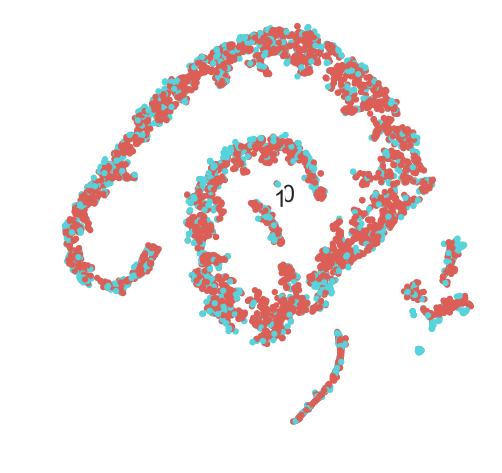

In [23]:

from sklearn.manifold import TSNE
import time
time_start = time.time()
X=data.drop(columns=["CHURN",'START_DATE','ID', 'AVG_DATA_3MONTH', 'COUNT_CONNECTIONS_3MONTH', 'AVG_DATA_1MONTH'])
X.fillna(0, inplace=True)
print(X.shape)
fashion_tsne = TSNE(random_state=42).fit_transform(X)

print( 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
fashion_scatter(fashion_tsne, data["CHURN"])

### Dimensionality reduction with Principal Component Analysis

We are going to apply PCA to drop high correlated Variables

#### Delay related variables

In [422]:
# Set 1
#COUNT_PAYMENT_DELAYS_CURRENT       5000 non-null int64
#COUNT_PAYMENT_DELAYS_1YEAR         5000 non-null int64
#DAYS_PAYMENT_DELAYS_CURRENT        5000 non-null int64
#DAYS_PAYMENT_DELAYS_1YEAR          5000 non-null int64

featuresToAnalyze=["DAYS_PAYMENT_DELAYS_CURRENT","COUNT_PAYMENT_DELAYS_CURRENT","COUNT_PAYMENT_DELAYS_1YEAR","DAYS_PAYMENT_DELAYS_1YEAR"]
pca = PCA(n_components=2)
df_projected = pca.fit_transform(data[featuresToAnalyze])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)
print("\n***Explained Variability")
diccionario={}
for i, a in enumerate(pca.components_):
    diccionario["Variability PC "+str(i+1)]=a
pd.DataFrame(diccionario, index=featuresToAnalyze).sort_values(ascending=False, by="Variability PC 1")

      Explained Variance  Cumulative Variance
PC 1              0.9634               0.9634
PC 2              0.0362               0.9996

***Explained Variability


,Variability PC 1,Variability PC 2
DAYS_PAYMENT_DELAYS_1YEAR,0.983857,-0.177630
COUNT_PAYMENT_DELAYS_1YEAR,0.013589,-0.047032
COUNT_PAYMENT_DELAYS_CURRENT,0.003162,0.013154
DAYS_PAYMENT_DELAYS_CURRENT,-0.178414,-0.982885


In [387]:
#correlation Betwenn 2 componets
data["DAYS_PAYMENT_DELAYS_1YEAR"].corr(data["DAYS_PAYMENT_DELAYS_CURRENT"])

-0.6575831842796517

#### Complaints related data

For Delay of Payment **DAYS_PAYMENT_DELAYS_1YEAR** as well as **DAYS_PAYMENT_DELAYS_CURRENT** is selected

In [389]:
# Set 1
#COMPLAINT_1MONTH                   5000 non-null int64
#COMPLAINT_3MONTHS                  5000 non-null int64
#COMPLAINT_6MONTHS                  5000 non-null int64

featuresToAnalyze=["COMPLAINT_1MONTH","COMPLAINT_3MONTHS","COMPLAINT_6MONTHS"]
pca = PCA(n_components=2)
df_projected = pca.fit_transform(data[featuresToAnalyze])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)
print("\n***Explained Variability")
diccionario={}
for i, a in enumerate(pca.components_):
    diccionario["Variability PC "+str(i+1)]=a
pd.DataFrame(diccionario, index=featuresToAnalyze).sort_values(ascending=False, by="Variability PC 1")

      Explained Variance  Cumulative Variance
PC 1              0.8761               0.8761
PC 2              0.1003               0.9764

***Explained Variability


,Variability PC 1,Variability PC 2
COMPLAINT_6MONTHS,0.831905,0.554821
COMPLAINT_3MONTHS,0.552574,-0.826523
COMPLAINT_1MONTH,0.050964,-0.095042


In [390]:
data["COMPLAINT_6MONTHS"].corr(data["COMPLAINT_3MONTHS"])

0.7706100801608154

Seems that **COMPLAINT_6MONTHS** and **COMPLAINT_3MONTHS** could be selected

#### Data Connection Related

In [391]:
#AVG_DATA_3MONTH                    3657 non-null float64
#COUNT_CONNECTIONS_3MONTH           3657 non-null float64
#AVG_DATA_1MONTH                    3657 non-null float64


featuresToAnalyze=["AVG_DATA_3MONTH","COUNT_CONNECTIONS_3MONTH","AVG_DATA_1MONTH"]
pca = PCA(n_components=2)
df_projected = pca.fit_transform(data[featuresToAnalyze])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)
print("\n***Explained Variability")
diccionario={}
for i, a in enumerate(pca.components_):
    diccionario["Variability PC "+str(i+1)]=a
pd.DataFrame(diccionario, index=featuresToAnalyze).sort_values(ascending=False, by="Variability PC 1")

      Explained Variance  Cumulative Variance
PC 1              0.9688               0.9688
PC 2              0.0312               1.0000

***Explained Variability


,Variability PC 1,Variability PC 2
AVG_DATA_3MONTH,9.594531e-01,2.818685e-01
AVG_DATA_1MONTH,2.818685e-01,-9.594531e-01
COUNT_CONNECTIONS_3MONTH,2.691449e-09,-2.471598e-09


In [392]:
data["AVG_DATA_3MONTH"].corr(data["AVG_DATA_1MONTH"])

0.8246306503675583

**AVG_DATA_3MONTH** and **AVG_DATA_1MONTH** could be used

####  Incoming sms related

In [394]:
#COUNT_SMS_INC_ONNET_6MONTH         5000 non-null int64
#COUNT_SMS_INC_OFFNET_1MONTH        5000 non-null int64
#COUNT_SMS_INC_OFFNET_WKD_1MONTH    5000 non-null int64
#COUNT_SMS_INC_ONNET_1MONTH         5000 non-null int64
#COUNT_SMS_INC_ONNET_WKD_1MONTH     5000 non-null int64

#COUNT_SMS_OUT_OFFNET_1MONTH        5000 non-null int64
#COUNT_SMS_OUT_OFFNET_WKD_1MONTH    5000 non-null int64
#COUNT_SMS_OUT_ONNET_1MONTH         5000 non-null int64
#COUNT_SMS_OUT_ONNET_WKD_1MONTH     5000 non-null int64
#COUNT_SMS_OUT_OFFNET_6MONTH        5000 non-null int64

featuresToAnalyze=["COUNT_SMS_INC_ONNET_6MONTH","COUNT_SMS_INC_OFFNET_1MONTH","COUNT_SMS_INC_OFFNET_WKD_1MONTH","COUNT_SMS_INC_ONNET_1MONTH","COUNT_SMS_INC_ONNET_WKD_1MONTH"]
pca = PCA(n_components=4)
df_projected = pca.fit_transform(data[featuresToAnalyze])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)
print("\n***Explained Variability")
diccionario={}
for i, a in enumerate(pca.components_):
    diccionario["Variability PC "+str(i+1)]=a
pd.DataFrame(diccionario, index=featuresToAnalyze).sort_values(ascending=False, by="Variability PC 1")

      Explained Variance  Cumulative Variance
PC 1              0.9611               0.9611
PC 2              0.0380               0.9991
PC 3              0.0007               0.9998
PC 4              0.0002               1.0000

***Explained Variability


,Variability PC 1,Variability PC 2,Variability PC 3,Variability PC 4
COUNT_SMS_INC_ONNET_6MONTH,0.992999,-0.118085,-0.000385,-0.002876
COUNT_SMS_INC_ONNET_1MONTH,0.112017,0.933659,0.009800,0.339994
COUNT_SMS_INC_ONNET_WKD_1MONTH,0.037471,0.338110,-0.039579,-0.939362
COUNT_SMS_INC_OFFNET_1MONTH,0.000748,0.004065,0.971288,-0.035019
COUNT_SMS_INC_OFFNET_WKD_1MONTH,0.000175,0.001018,0.234385,-0.027728


In [396]:
data["COUNT_SMS_INC_ONNET_6MONTH"].corr(data["COUNT_SMS_INC_ONNET_1MONTH"])

0.4961717158385029

**COUNT_SMS_INC_ONNET_6MONTH** and **COUNT_SMS_INC_ONNET_1MONTH** could be used

In [397]:

#COUNT_SMS_OUT_OFFNET_1MONTH        5000 non-null int64
#COUNT_SMS_OUT_OFFNET_WKD_1MONTH    5000 non-null int64
#COUNT_SMS_OUT_ONNET_1MONTH         5000 non-null int64
#COUNT_SMS_OUT_ONNET_WKD_1MONTH     5000 non-null int64
#COUNT_SMS_OUT_OFFNET_6MONTH        5000 non-null int64

featuresToAnalyze=["COUNT_SMS_OUT_OFFNET_1MONTH","COUNT_SMS_OUT_OFFNET_WKD_1MONTH","COUNT_SMS_OUT_ONNET_1MONTH","COUNT_SMS_OUT_ONNET_WKD_1MONTH","COUNT_SMS_OUT_OFFNET_6MONTH"]
pca = PCA(n_components=4)
df_projected = pca.fit_transform(data[featuresToAnalyze])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)
print("\n***Explained Variability")
diccionario={}
for i, a in enumerate(pca.components_):
    diccionario["Variability PC "+str(i+1)]=a
pd.DataFrame(diccionario, index=featuresToAnalyze).sort_values(ascending=False, by="Variability PC 1")

      Explained Variance  Cumulative Variance
PC 1              0.8140               0.8140
PC 2              0.1616               0.9756
PC 3              0.0203               0.9959
PC 4              0.0031               0.9990

***Explained Variability


,Variability PC 1,Variability PC 2,Variability PC 3,Variability PC 4
COUNT_SMS_OUT_OFFNET_6MONTH,0.984738,-0.065110,-0.161156,-0.007544
COUNT_SMS_OUT_OFFNET_1MONTH,0.157678,-0.002864,0.956273,0.020468
COUNT_SMS_OUT_ONNET_1MONTH,0.063548,0.957673,-0.011485,0.280398
COUNT_SMS_OUT_OFFNET_WKD_1MONTH,0.034807,-0.001140,0.243475,-0.022653
COUNT_SMS_OUT_ONNET_WKD_1MONTH,0.013372,0.280381,0.012563,-0.959368


In [400]:
data["COUNT_SMS_OUT_OFFNET_6MONTH"].corr(data["COUNT_SMS_OUT_ONNET_1MONTH"])

0.11806770220837731

**COUNT_SMS_OUT_OFFNET_6MONTH** and **COUNT_SMS_OUT_ONNET_1MONTH**

In [402]:
#AVG_MINUTES_INC_OFFNET_1MONTH      5000 non-null float64
#AVG_MINUTES_INC_ONNET_1MONTH       5000 non-null float64
#MINUTES_INC_OFFNET_WKD_1MONTH      5000 non-null float64
#MINUTES_INC_ONNET_WKD_1MONTH       5000 non-null float64
#AVG_MINUTES_OUT_OFFNET_1MONTH      5000 non-null float64
#AVG_MINUTES_OUT_ONNET_1MONTH       5000 non-null float64
#MINUTES_OUT_OFFNET_WKD_1MONTH      5000 non-null float64
#MINUTES_OUT_ONNET_WKD_1MONTH       5000 non-null float64

featuresToAnalyze=["AVG_MINUTES_INC_OFFNET_1MONTH","AVG_MINUTES_INC_ONNET_1MONTH","MINUTES_INC_OFFNET_WKD_1MONTH","MINUTES_INC_ONNET_WKD_1MONTH","AVG_MINUTES_OUT_OFFNET_1MONTH","AVG_MINUTES_OUT_ONNET_1MONTH","MINUTES_OUT_OFFNET_WKD_1MONTH","MINUTES_OUT_ONNET_WKD_1MONTH"]
pca = PCA(n_components=8)
df_projected = pca.fit_transform(data[featuresToAnalyze])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)
print("\n***Explained Variability")
diccionario={}
for i, a in enumerate(pca.components_):
    diccionario["Variability PC "+str(i+1)]=a
pd.DataFrame(diccionario, index=featuresToAnalyze).sort_values(ascending=False, by="Variability PC 1")

      Explained Variance  Cumulative Variance
PC 1              0.5030               0.5030
PC 2              0.1900               0.6930
PC 3              0.1504               0.8434
PC 4              0.0804               0.9238
PC 5              0.0348               0.9586
PC 6              0.0185               0.9771
PC 7              0.0127               0.9898
PC 8              0.0102               1.0000

***Explained Variability


,Variability PC 1,Variability PC 2,Variability PC 3,Variability PC 4,Variability PC 5,Variability PC 6,Variability PC 7,Variability PC 8
AVG_MINUTES_INC_ONNET_1MONTH,0.695628,-0.193503,0.671861,-0.087782,-0.134815,0.026390,0.026148,-0.000570
AVG_MINUTES_OUT_ONNET_1MONTH,0.665963,-0.054340,-0.724560,0.080927,-0.145890,0.025101,-0.007782,-0.005401
AVG_MINUTES_INC_OFFNET_1MONTH,0.153721,0.809519,0.137961,0.494868,-0.045021,-0.218177,0.003863,-0.086479
MINUTES_INC_ONNET_WKD_1MONTH,0.142414,-0.052830,0.009677,0.046963,0.674255,-0.089544,-0.706415,-0.113874
MINUTES_OUT_ONNET_WKD_1MONTH,0.132268,-0.030888,-0.023985,0.035210,0.685938,-0.150146,0.678741,0.161219
AVG_MINUTES_OUT_OFFNET_1MONTH,0.099845,0.512704,-0.052194,-0.839010,0.052100,-0.024125,-0.041955,0.124281
MINUTES_INC_OFFNET_WKD_1MONTH,0.031695,0.178763,0.033725,0.155591,0.134544,0.872715,-0.042882,0.400151
MINUTES_OUT_OFFNET_WKD_1MONTH,0.014639,0.075605,-0.007212,-0.096219,0.112103,0.397865,0.189550,-0.882024


# Initial data training and Test Data
(Final Data Model Training and testing Next Notebook)

In [96]:
#Drop Individual Outliers
#Outlier: max value in AVG_DATA_3MONTH 
data=data.drop([1934])

### Data Partitioning

In [97]:
#Partitioning the data
X=data.drop(["CHURN"], axis=1)
y=data["CHURN"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [98]:
medianAvg3m=X_train["AVG_DATA_3MONTH"].median()
medianCounCon3M=X_train["COUNT_CONNECTIONS_3MONTH"].median()
medianAvg1M=X_train["AVG_DATA_1MONTH"].median()
print(" Median AVG_DATA_3MONTH: "+str(medianAvg3m))
print(" Median COUNT_CONNECTIONS_3MONTH: "+str(medianCounCon3M))
print(" Median AVG_DATA_1MONTH: "+str(medianAvg1M))


 Median AVG_DATA_3MONTH: 561420282.0
 Median COUNT_CONNECTIONS_3MONTH: 71.0
 Median AVG_DATA_1MONTH: 127256786.0


In [99]:
X_train["AVG_DATA_3MONTH"].fillna(561420282, inplace=True)
X_train["COUNT_CONNECTIONS_3MONTH"].fillna(71, inplace=True)
X_train["AVG_DATA_1MONTH"].fillna(127256786, inplace=True)

X_test["AVG_DATA_3MONTH"].fillna(561420282, inplace=True)
X_test["COUNT_CONNECTIONS_3MONTH"].fillna(71, inplace=True)
X_test["AVG_DATA_1MONTH"].fillna(127256786, inplace=True)

c:\program files\python36\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [100]:
#Verify CHURN Distribution
y_train.value_counts(normalize=True)

0    0.710678
1    0.289322
Name: CHURN, dtype: float64

In [101]:
#Verify CHURN Distribution
y_test.value_counts(normalize=True)

0    0.711
1    0.289
Name: CHURN, dtype: float64

In [102]:
#Create Features for the traning and the test set separated
X_train.loc[:,"CALL_NET_SIZE_WKD"]=(X_train["MINUTES_OUT_ONNET_WKD_1MONTH"]/(X_train["MINUTES_OUT_ONNET_WKD_1MONTH"]+X_train["MINUTES_OUT_OFFNET_WKD_1MONTH"]))
X_train.loc[:,"SMS_NET_SIZE_1MONTH"]=(X_train["COUNT_SMS_OUT_ONNET_1MONTH"]/(X_train["COUNT_SMS_OUT_ONNET_1MONTH"]+X_train["COUNT_SMS_OUT_OFFNET_1MONTH"]))
X_train["CALL_NET_SIZE_WKD"].fillna(0, inplace=True)
X_train["SMS_NET_SIZE_1MONTH"].fillna(0, inplace=True)

X_test.loc[:,"CALL_NET_SIZE_WKD"]=(X_test["MINUTES_OUT_ONNET_WKD_1MONTH"]/(X_test["MINUTES_OUT_ONNET_WKD_1MONTH"]+X_test["MINUTES_OUT_OFFNET_WKD_1MONTH"]))
X_test.loc[:,"SMS_NET_SIZE_1MONTH"]=(X_test["COUNT_SMS_OUT_ONNET_1MONTH"]/(X_test["COUNT_SMS_OUT_ONNET_1MONTH"]+X_test["COUNT_SMS_OUT_OFFNET_1MONTH"]))
X_test["CALL_NET_SIZE_WKD"].fillna(0, inplace=True)
X_test["SMS_NET_SIZE_1MONTH"].fillna(0, inplace=True)

c:\program files\python36\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\program files\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\program files\python36\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [103]:
#Finally drop Index column, before feeding ML Models
X_train=X_train.drop(["ID"], axis=1)
X_test=X_test.drop(["ID"], axis=1)

### Oversampling

In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [104]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [76]:
X_train.shape

1    0.5
0    0.5
dtype: float64

### Feature Rescaling

In [132]:
#Not sure about this
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)
X_train=transformer.transform(X_train)
X_test=transformer.transform(X_test)

### Linear Regression 
This is not correct since churn is binary

In [84]:
import sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)
#y_pred=reg.predict(X_test)
#0.21690470915403703

0.07899913850277673

### Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs')
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)
#(0.714, 0.5051903114186851)

Accuracy on TEST set: 0.770
AUC BASE on TEST set: 0.759


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.77, 0.7591870702115545)

In [86]:
from sklearn.tree import DecisionTreeRegressor
clf=DecisionTreeRegressor(random_state=0)
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)
#(0.816, 0.7751059718998048)

Accuracy on TEST set: 0.781
AUC BASE on TEST set: 0.750


(0.781, 0.7504927510840523)

### Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=None, n_jobs=-1, verbose=1, random_state = 42)
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s


Accuracy on TEST set: 0.877
AUC BASE on TEST set: 0.847


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.6s finished


(0.877, 0.8467556295290516)

# Useful Functions

This is a repository for rapid graphics generation, feature transformation etc.

In [68]:
# function to return accuracy and auc of a given model
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("Accuracy on TEST set: {:.3f}".format(accuracy))
    print("AUC BASE on TEST set: {:.3f}".format(roc_auc))
    return accuracy, roc_auc

In [192]:
pd.set_option('display.max_columns', 500)
data.describe()

,ID,CHURN,PREPAID,COUNT_PAYMENT_DELAYS_CURRENT,COUNT_PAYMENT_DELAYS_1YEAR,DAYS_PAYMENT_DELAYS_CURRENT,DAYS_PAYMENT_DELAYS_1YEAR,COMPLAINT_1MONTH,COMPLAINT_3MONTHS,COMPLAINT_6MONTHS,CLV,COUNT_OFFNET_CALLS_1WEEK,COUNT_ONNET_CALLS_1WEEK,AVG_DATA_3MONTH,COUNT_CONNECTIONS_3MONTH,AVG_DATA_1MONTH,COUNT_SMS_INC_ONNET_6MONTH,COUNT_SMS_OUT_OFFNET_6MONTH,COUNT_SMS_INC_OFFNET_1MONTH,COUNT_SMS_INC_OFFNET_WKD_1MONTH,COUNT_SMS_INC_ONNET_1MONTH,COUNT_SMS_INC_ONNET_WKD_1MONTH,COUNT_SMS_OUT_OFFNET_1MONTH,COUNT_SMS_OUT_OFFNET_WKD_1MONTH,COUNT_SMS_OUT_ONNET_1MONTH,COUNT_SMS_OUT_ONNET_WKD_1MONTH,AVG_MINUTES_INC_OFFNET_1MONTH,AVG_MINUTES_INC_ONNET_1MONTH,MINUTES_INC_OFFNET_WKD_1MONTH,MINUTES_INC_ONNET_WKD_1MONTH,AVG_MINUTES_OUT_OFFNET_1MONTH,AVG_MINUTES_OUT_ONNET_1MONTH,MINUTES_OUT_OFFNET_WKD_1MONTH,MINUTES_OUT_ONNET_WKD_1MONTH,PLAN_DURATION_DAYS,HAS_DATA_PLAN
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4.999000e+03,4999.000000,4.999000e+03,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,13525.354071,0.289258,0.232046,0.115423,2.529106,-5.230846,37.599120,0.035807,0.385677,0.709942,19861.868976,17.940788,30.479296,1.682773e+09,48.234447,5.795534e+08,465.761152,88.731346,14.137828,3.321664,83.489298,20.605721,16.205041,3.513303,25.206441,5.972394,63.287675,78.211937,26.396239,30.198638,58.697679,81.072257,24.157624,31.180995,691.482897,0.731346
std,2022.090056,0.453463,0.422181,0.477673,2.719938,27.231014,102.705154,0.267856,0.954802,1.314296,15238.507169,22.407234,45.846482,4.853407e+09,49.504639,1.668686e+09,1349.547414,166.755610,36.152538,10.652584,294.639913,106.094748,36.956781,10.462426,73.058442,23.499637,109.065116,154.171397,43.146788,49.784126,91.354365,150.314137,31.934817,48.812079,781.903955,0.443304
min,10002.000000,0.000000,0.000000,0.000000,0.000000,-340.000000,0.000000,0.000000,0.000000,0.000000,-43113.980000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000
25%,11798.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,11396.815000,2.000000,2.000000,0.000000e+00,0.000000,0.000000e+00,72.000000,11.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,2.000000,0.000000,12.381667,8.241667,2.083333,0.158333,12.316667,12.450000,1.100000,1.750000,218.000000,0.000000
50%,13529.000000,0.000000,0.000000,0.000000,2.000000,0.000000,9.000000,0.000000,0.000000,0.000000,16890.750000,11.000000,16.000000,1.022905e+08,35.000000,1.135222e+07,291.000000,38.000000,2.000000,0.000000,48.000000,10.000000,5.000000,0.000000,10.000000,2.000000,32.906667,29.083333,16.550000,15.833333,30.983333,33.400000,14.616667,17.516667,451.000000,1.000000
75%,15268.500000,1.000000,0.000000,0.000000,4.000000,0.000000,29.000000,0.000000,0.000000,1.000000,24825.135000,25.500000,41.000000,1.437779e+09,91.000000,4.248511e+08,578.500000,96.000000,12.000000,2.000000,104.000000,24.000000,16.000000,3.000000,25.000000,6.000000,72.666667,78.700000,37.269167,41.050000,69.450000,82.783333,34.333333,42.348333,826.500000,1.000000
max,17033.000000,1.000000,1.000000,7.000000,18.000000,0.000000,1653.000000,6.000000,8.000000,12.000000,225838.800000,266.000000,867.000000,1.334680e+11,236.000000,2.876661e+10,70946.000000,2887.000000,628.000000,211.000000,19178.000000,7121.000000,603.000000,214.000000,2999.000000,1089.000000,2659.116667,2366.750000,1972.383333,833.050000,1006.916667,2011.100000,671.800000,820.700000,5553.000000,1.000000


In [193]:
def basicGraphics(df,column):
    """This function generates a Boxplot, Distribution, and Histogram for the given variable"""    
    plt.subplots_adjust(top=0.8, bottom=0.2)
    plt.figure(figsize=(8,12))    
    plt.subplot(3, 1, 1)
    plt.title(column)
    sns.boxplot(df[column])
    plt.xlabel('boxplot')
    plt.subplot(3, 1, 2)
    sns.distplot(df[column])
    plt.xlabel('Distribution')
    plt.subplot(3, 1, 3)
    df[column].hist(bins=50)
    plt.xlabel('Histogram')
    plt.show()
## Usage
#basicGraphics(data,"COUNT_SMS_OUT_OFFNET_6MONTH")



def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """This function generates a histogram for the all variables in the dataset and save it into a file"""
    mpl.rc('axes', labelsize=14)
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', labelsize=12)

    # Where to save the figures
    PROJECT_ROOT_DIR = "."
    IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    print("in path", path)

    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

    # Ignore useless warnings (see SciPy issue #5998)
    import warnings
    warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Usage
#data.hist(bins=50, figsize=(40,20))
#save_fig("attribute_histogram_plots")

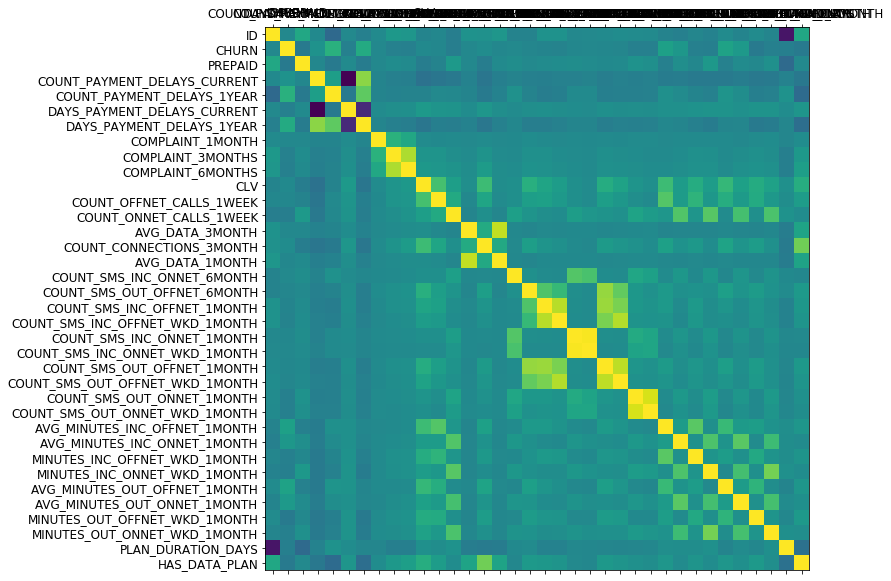

In [194]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
## Usage
plot_corr(data)

In [195]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,ID,CHURN,PREPAID,COUNT_PAYMENT_DELAYS_CURRENT,COUNT_PAYMENT_DELAYS_1YEAR,DAYS_PAYMENT_DELAYS_CURRENT,DAYS_PAYMENT_DELAYS_1YEAR,COMPLAINT_1MONTH,COMPLAINT_3MONTHS,COMPLAINT_6MONTHS,CLV,COUNT_OFFNET_CALLS_1WEEK,COUNT_ONNET_CALLS_1WEEK,AVG_DATA_3MONTH,COUNT_CONNECTIONS_3MONTH,AVG_DATA_1MONTH,COUNT_SMS_INC_ONNET_6MONTH,COUNT_SMS_OUT_OFFNET_6MONTH,COUNT_SMS_INC_OFFNET_1MONTH,COUNT_SMS_INC_OFFNET_WKD_1MONTH,COUNT_SMS_INC_ONNET_1MONTH,COUNT_SMS_INC_ONNET_WKD_1MONTH,COUNT_SMS_OUT_OFFNET_1MONTH,COUNT_SMS_OUT_OFFNET_WKD_1MONTH,COUNT_SMS_OUT_ONNET_1MONTH,COUNT_SMS_OUT_ONNET_WKD_1MONTH,AVG_MINUTES_INC_OFFNET_1MONTH,AVG_MINUTES_INC_ONNET_1MONTH,MINUTES_INC_OFFNET_WKD_1MONTH,MINUTES_INC_ONNET_WKD_1MONTH,AVG_MINUTES_OUT_OFFNET_1MONTH,AVG_MINUTES_OUT_ONNET_1MONTH,MINUTES_OUT_OFFNET_WKD_1MONTH,MINUTES_OUT_ONNET_WKD_1MONTH,PLAN_DURATION_DAYS,HAS_DATA_PLAN
ID,1,-0.000477208,0.247449,0.0107209,-0.237104,0.00871396,-0.060276,0.0230965,0.124567,0.109384,-0.030895,-0.011331,-0.0770782,0.0796623,0.0746464,0.107491,-0.0416931,-0.0385341,0.0772953,0.0813162,-0.0031671,0.00455983,0.0200893,0.0344848,0.0284058,0.020455,-0.0377794,-0.0572336,-0.0185556,-0.0470658,0.0267344,-0.0321701,0.0281412,-0.0258054,-0.771229,0.244068
CHURN,-0.000477208,1,-0.111345,0.0813763,0.315989,-0.0635031,0.267423,-0.00128017,-0.0497646,-0.0606218,0.0155368,-0.00717509,-0.0738841,-0.00385262,0.038646,-0.00903538,0.00348796,-0.0127152,-0.0304419,-0.0381528,-0.00987388,-0.00396696,-0.00700209,-0.0150655,-0.0607712,-0.0585635,0.185686,0.113864,-0.060345,-0.0647919,0.204979,0.134657,-0.113006,-0.0610247,-0.0681775,-0.101051
PREPAID,0.247449,-0.111345,1,-0.0117974,-0.112692,0.0172085,-0.0892051,-0.00448752,0.0325681,0.0207221,-0.0841653,-0.0416939,0.136047,-0.00017249,-0.0842825,0.0199469,0.0447148,0.00938896,0.0295753,0.0328269,0.0401691,0.0262182,0.0141464,0.0193677,0.0813617,0.0559441,-0.0593162,0.0495895,-0.0108584,0.124425,-0.05544,0.0273382,0.000287173,0.0609364,-0.227426,0.00388961
COUNT_PAYMENT_DELAYS_CURRENT,0.0107209,0.0813763,-0.0117974,1,0.174896,-0.878456,0.670631,-0.0323086,-0.0620906,-0.0671295,-0.171068,-0.142869,-0.122294,-0.0433378,-0.139924,-0.070655,-0.0382648,-0.0595256,-0.069557,-0.0520838,-0.0496859,-0.034859,-0.0729937,-0.0506914,-0.0681636,-0.0536345,-0.0890874,-0.0792295,-0.10365,-0.106573,-0.100945,-0.0812204,-0.115544,-0.106566,-0.0481451,-0.12849
COUNT_PAYMENT_DELAYS_1YEAR,-0.237104,0.315989,-0.112692,0.174896,1,-0.103692,0.532779,-0.0320517,-0.0450789,-0.0410702,-0.0360991,0.00552713,-0.00144844,-0.0321467,-0.100945,-0.0453245,0.0700824,-0.0413987,-0.0843548,-0.0674576,0.0199243,0.0214174,-0.064722,-0.0597185,-0.0635488,-0.0500845,0.0662725,0.0292483,-0.0288499,-0.0560896,0.090167,0.0460415,-0.0661663,-0.0503723,0.0784056,-0.221926
DAYS_PAYMENT_DELAYS_CURRENT,0.00871396,-0.0635031,0.0172085,-0.878456,-0.103692,1,-0.657583,0.0256841,0.0521594,0.0575161,0.136436,0.0962064,0.0872734,0.0349965,0.107969,0.0528994,0.0285499,0.0503401,0.0570082,0.0436475,0.036148,0.0255892,0.0595752,0.0412119,0.0526039,0.0407406,0.0677412,0.0656953,0.07654,0.0829243,0.0860189,0.0663165,0.0884441,0.0863346,0.0321441,0.100756
DAYS_PAYMENT_DELAYS_1YEAR,-0.060276,0.267423,-0.0892051,0.670631,0.532779,-0.657583,1,-0.0244389,-0.0604426,-0.0714518,-0.141726,-0.0678503,-0.0715334,-0.045976,-0.13331,-0.0546488,-0.00776552,-0.078359,-0.0721675,-0.0508575,-0.0268709,-0.0238569,-0.0765323,-0.0554963,-0.0631454,-0.0503172,-0.00857948,-0.0251031,-0.0582361,-0.0931585,-0.0199943,-0.019178,-0.107174,-0.0927345,-0.0160868,-0.199275
COMPLAINT_1MONTH,0.0230965,-0.00128017,-0.00448752,-0.0323086,-0.0320517,0.0256841,-0.0244389,1,0.318379,0.247183,0.0306725,0.0138211,0.0172086,0.00467644,0.0271756,0.00420846,0.0100137,0.0382905,0.022342,0.00388625,0.0191772,0.0104382,0.0239774,0.0132166,0.030571,0.0259676,0.00823629,0.017583,0.0240497,0.0207874,0.0188058,-0.00143358,0.0278709,0.0338963,-0.0172659,0.0372201
COMPLAINT_3MONTHS,0.124567,-0.0497646,0.0325681,-0.0620906,-0.0450789,0.0521594,-0.0604426,

In [196]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

##Usage
print("Top Absolute Correlations")
print(get_top_abs_correlations(data, 50))

Top Absolute Correlations
COUNT_SMS_INC_ONNET_1MONTH       COUNT_SMS_INC_ONNET_WKD_1MONTH     0.981012
COUNT_SMS_OUT_ONNET_1MONTH       COUNT_SMS_OUT_ONNET_WKD_1MONTH     0.886078
COUNT_PAYMENT_DELAYS_CURRENT     DAYS_PAYMENT_DELAYS_CURRENT        0.878456
AVG_DATA_3MONTH                  AVG_DATA_1MONTH                    0.824631
COUNT_SMS_OUT_OFFNET_1MONTH      COUNT_SMS_OUT_OFFNET_WKD_1MONTH    0.814240
COUNT_SMS_INC_OFFNET_1MONTH      COUNT_SMS_INC_OFFNET_WKD_1MONTH    0.794831
COUNT_SMS_INC_OFFNET_WKD_1MONTH  COUNT_SMS_OUT_OFFNET_WKD_1MONTH    0.786045
ID                               PLAN_DURATION_DAYS                 0.771229
COMPLAINT_3MONTHS                COMPLAINT_6MONTHS                  0.770610
COUNT_SMS_INC_OFFNET_1MONTH      COUNT_SMS_OUT_OFFNET_1MONTH        0.717318
COUNT_SMS_OUT_OFFNET_6MONTH      COUNT_SMS_OUT_OFFNET_1MONTH        0.703732
COUNT_PAYMENT_DELAYS_CURRENT     DAYS_PAYMENT_DELAYS_1YEAR          0.670631
DAYS_PAYMENT_DELAYS_CURRENT      DAYS_PAYMENT_DELA